Make imports.

In [1]:
# MODULE IMPORTS
import os
import sys
sys.path.append("..")
from deconfounder.causal_tree import CausalTree
# OTHER IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from numpy.polynomial.polynomial import polyfit
import pandas as pd
from sklearn.model_selection import train_test_split

Generate random data.

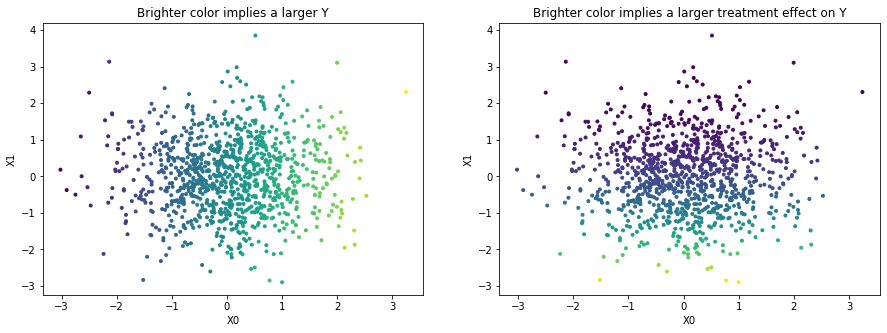

In [2]:
np.random.seed(42)
X = np.random.normal(size=(1000,4))
alpha = [16, -8]
t = (X[:, 0] + X[:, 3] * 0.5) > 0
switch = np.zeros(X.shape[0])
switch[t] = 1
treated = np.random.binomial(1, 0.5, X.shape[0])> 0
effs = X[:, 1]**2 - X[:, 1]*5
y = X[:, 0]*40 + effs*treated + X[:, 2]*2

fig, ax = plt.subplots(1, 2, figsize=(15,5))
# Plot outcomes in terms of features
ax[0].scatter(X[:, 0], X[:, 1], c=y, marker=".")
ax[0].set_title("Brighter color implies a larger Y")
ax[0].set_xlabel("X0")
ax[0].set_ylabel("X1")
# Plot effects in terms of features
ax[1].scatter(X[:, 0], X[:, 1], c=effs, marker=".")
ax[1].set_title("Brighter color implies a larger treatment effect on Y")
ax[1].set_xlabel("X0")
ax[1].set_ylabel("X1")

plt.show()

Select the features (plus the treatment assignment) and split the data into train and test.

In [3]:
df_full = pd.DataFrame(X)
df_full['treated'] = treated
df = df_full.iloc[:, [0, 1, 4]]
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)
effs_test = effs[X_test.index.values]
df.head()

,0,1,treated
0,0.496714,-0.138264,False
1,-0.234153,-0.234137,False
2,-0.469474,0.542560,True
3,0.241962,-1.913280,True
4,-1.012831,0.314247,True


Build a standard tree regressor to predict outcomes.

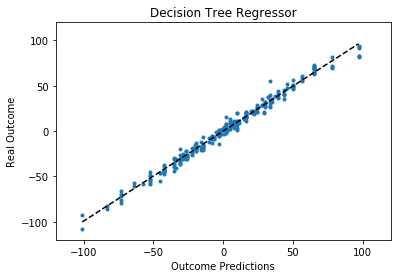

In [4]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(min_samples_leaf=10, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
fig, ax = plt.subplots(1, 1)
ax.plot(pred, y_test, ".")
# Regression line
b, m = polyfit(pred, y_test, 1)
sorted_pred = np.sort(pred)
reg_line = b + m*sorted_pred
ax.plot(sorted_pred, reg_line, "--", color='black')
# Format chart
ax.set_title("Decision Tree Regressor")
ax.set_xlabel("Outcome Predictions")
ax.set_ylabel("Real Outcome")
ax.set_xlim(-120, 120)
ax.set_ylim(-120, 120)
plt.show()

Use the regressor tree to predict treatment effects. Since the tree does not use the treatment assignment to split, it does not detect any effect.

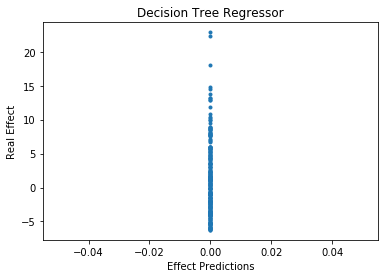

In [5]:
#Use the model to predict causal effects
X_treated = X_test.copy()
X_treated.treated = True
X_untreated = X_test.copy()
X_untreated.treated = False
pred = model.predict(X_treated) - model.predict(X_untreated) 

fig, ax = plt.subplots(1, 1)
ax.plot(pred, effs_test, ".")
ax.set_title("Decision Tree Regressor")
ax.set_xlabel("Effect Predictions")
ax.set_ylabel("Real Effect")
plt.show()

As a competing alternative, build a causal tree (a regression tree that splits according to treatment effects). Despite its high variance, this tree does a great job a discriminating between users that benefit from the treatment and users that don't.

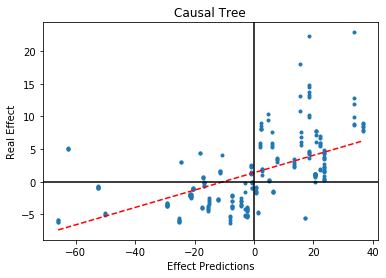

In [6]:
causal_model = CausalTree(min_samples_leaf=10, random_state=42)
causal_model.fit(X_train, y_train)
pred = causal_model.predict(X_test)

def plot_causal_tree_results(pred):
    fig, ax = plt.subplots(1, 1)
    ax.plot(pred, effs_test, ".")
    # Regression line
    b, m = polyfit(pred, effs_test, 1)
    sorted_pred = np.sort(pred)
    reg_line = b + m*sorted_pred
    ax.plot(sorted_pred, reg_line, "--", color='red')
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    # Format chart
    ax.set_title("Causal Tree")
    ax.set_xlabel("Effect Predictions")
    ax.set_ylabel("Real Effect")
    plt.show()
    
plot_causal_tree_results(pred)

The code below tunes the causal tree. The range of the causal-effect predictions matches the actual effects much better, and treatment assignments would be nearly optimal with this model.

Best parameters set found on development set:
{'min_samples_leaf': 230}


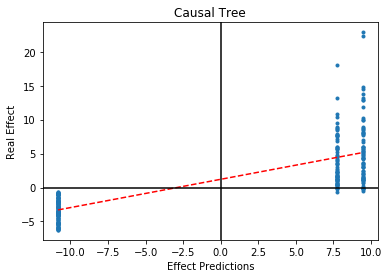

In [7]:
from sklearn.model_selection import GridSearchCV
 
tuned_parameters = [{'min_samples_leaf': range(10, 300, 10)}]
clf = GridSearchCV(CausalTree(), tuned_parameters, cv=10)
clf.fit(df, y)
print("Best parameters set found on development set:")
print(clf.best_params_)
pred = clf.predict(X_test)
plot_causal_tree_results(pred)

For more information about building splitting criterions for the sklearn tree, check out this post:

http://www.xavierdupre.fr/app/mlinsights/helpsphinx/notebooks/piecewise_linear_regression_criterion.html